**Instituto Tecnológico de Costa Rica**  
**Maestría en Electrónica**  
**MP6124. Procesamiento Adaptativo**    
**Profesor:** Juan Pablo Soto Quirós  
**Estudiantes:**  
- Juan Carlos Cruz Naranjo  
- Luis Alonso Murillo Rojas

## Tarea 2

### Problema 1.
Del libro _Fundamentals of Adaptive Filtering_ de Ali Sayed, implemente cada uno de los algoritmos de
gradiente estocástico que se encuentran en la **Tabla 5.1.**, página 230. 

<div style="align: left; text-align:center;">
<img src="tabla5.1.png" style="width:350px;"/>
<figcaption>Tabla 5.1. Algoritmos de Gradiente Estocástico</figcaption>
</div>

Cada uno de los algoritmos de la Tabla 5.1. da una aproximación a la solución del problema de optimización:  

<center>$\underset{w \in \mathbb{C}^{n}}{\text{min}}\mathbb{E}[|\textbf{d-u}w|^{2}]$</center>

donde $\textbf{d}$ es una variable aleatoria, $\textbf{u}$ es un vector fila aleatorio de tamaño _n_ y $w$ es un vector columna constante de tamaño _n_. Para la implementación de cada algoritmo, considere las siguientes indicaciones:
- Cada algoritmo debe ser implementado como una función.
- Los parámetros iniciales de cada función son los siguientes:
 - Observaciones de la variable aleatoria $\textbf{d}$ que se representan en el vector $d=[d_0\text{  }d_1\text{  }...\text{  }d_{s−1}]\in \mathbb{C}^{s}$, donde $d_j \in \mathbb{C}$ es la observación $j$ de $\textbf{d}$.  
 - Observaciones del vector aleatorio $\textbf{u}$, que se representan en la matriz $U= 
\begin{bmatrix} 
u_0 \\
\vdots \\
u_{s-1}
\end{bmatrix} \in \mathbb{C}^{s\times n}$, donde $u_j \in \mathbb{C}^{n}$ es la observación $j$ de $\textbf{u}$.

 - Vector inicial $w^{(−1)} \in \mathbb{C}^m$, el cual es un vector columna.
 - Tolerancia $tol > 0$ para el criterio de parada.
 - Iteraciones máximas $iterMax > 0$.
- Los parámetros finales son el número de iteraciones $k$ y el vector $w^{(k)}$ que aproxima la solución del problema (1).
- Utilice nombres significativos para definir cada una de las funciones.
- El criterio de parada de cada algoritmo será la condición $||w^{(k)} - w^{(k−1)}||_2 < tol$ o cuando el número de iteraciones es mayor a $iterMax$.

- En el método LMS con tamaño de paso variante, puede utilizar como tamaño de paso $\mu_i = \frac{2}{1+i}$ en cada iteración. Si considera oportuno, puede utilizar otro tamaño de paso. De ser así, debe justificar porque seleccionó otro tamaño de paso $\mu_i$.
- Cada método debe generar dos gráficas: una de iteraciones versus error y otra de iteraciones versus valor mínimo. El error se medirá con el criterio $e_k = ||w^{(k)} - w^{(k−1)}||_2$ y el valor mínimo se medirá con el criterio:

<center>$m_k = \hat{R}_{d_kd_k}-\left(\hat{R}_{d_ku_k}\right)^{*}w^{(k)}-\left(w^{(k)}\right)^{*}\hat{R}_{d_ku_k} + \left(w^{(k)}\right)^{*}\hat{R}_{u_ku_k}w^{(k)}$</center>


Donde $\hat{R}_{d_kd_k}=d_k(d_k)^*$, $\hat{R}_{d_ku_k}=d_k(u_k)^*$ y $\hat{R}_{u_ku_k}=(u_k)^*u_k$.

In [95]:
# Required Libraries

import numpy as np
import matplotlib.pyplot as plt


# Plotter
def plot_iterations(n_iterations, y_vector_a, y_vector_b, title):
    x = np.linspace(0, n_iterations, num = n_iterations)
    plt.suptitle(title, fontsize = 16)
    plt.subplot(2,1,1)
    plt.plot(x, y_vector_a, '-')
    plt.title("Error vs iterations")
    plt.xlabel("iterations")
    plt.ylabel("error e_k")
    plt.grid()
    plt.show()
    
    plt.subplot(2,1,2)
    plt.plot(x, y_vector_b, '-')
    plt.title("Minimum vs iterations")
    plt.xlabel("iterations")
    plt.ylabel("minimum m_k")
    plt.grid()
    plt.show()

    
# Algorithm 1.1. LMS with constant step-size
def lms_constant_step_size(d, U, w_k, tol, iterMax):
    s = np.shape(U)[0]                               # Rows of U
    mu = 0.5                                         # Step size. Usually 2^(-m) for m > 0. In this case: m=1
    ek_vector = []
    mk_vector = []
    k_iterations = 0
    solution = None
    plot_title = "LMS with constant step-size"
    if iterMax >= s:
        print("iterMax must be lower than matrix U rows quantity!")
        return
    for k in range(iterMax):
        uk = U[k]                                                               # Vector uk from the U matrix
        uk_conj = np.conj(uk)                                                   # Conjugate uk* of uk vector
        dk = d[k]                                                               # Observation of d
        dk_conj = np.conj(dk)                                                   # Conjugate dk* of dk observation
        estk = dk - uk * w_k                                                    # A priori output estimation error
        wk = w_k + (mu * uk_conj * estk)                                        # Update the solution
        wk_conj = np.conj(wk)                                                   # Conjugate wk* of wk vector
        ek = np.linalg.norm(wk - w_k)                                           # Error
        ek_vector.append(ek)                                                    # Vector of error values
        Rdd = dk * dk_conj
        Rdu = dk * uk_conj
        Ruu = uk_conj * uk
        mk = Rdd - (np.conj(Rdu) * wk) - (wk_conj * Rdu) + (wk_conj * Ruu * wk) # Minimum value
        mk_vector.append(mk)                                                    # Vector of minimum values
        w_k = wk
        solution = wk
        k_iterations = k + 1
        if ek < tol:
            print("Tolerance reached!")
            break
    plot_iterations(k_iterations, ek_vector, mk_vector, plot_title)             # Calling the plotter
    return (k_iterations, solution)


# Algorithm 1.2. LMS with time-variant step-size
def lms_time_variant_step_size(d, U, w_k, tol, iterMax):
    s = np.shape(U)[0]                               # Rows of U
    ek_vector = []
    mk_vector = []
    k_iterations = 0
    solution = None
    plot_title = "LMS with time-variant step-size"
    if iterMax >= s:
        print("iterMax must be lower than matrix U rows quantity!")
        return
    for k in range(iterMax):
        mu = 2.0 / (1 + k)                                                      # Time-variant step size
        uk = U[k]                                                               # Vector uk from the U matrix
        uk_conj = np.conj(uk)                                                   # Conjugate uk* of uk vector
        dk = d[k]                                                               # Observation of d
        dk_conj = np.conj(dk)                                                   # Conjugate dk* of dk observation
        estk = dk - uk * w_k                                                    # A priori output estimation error
        wk = w_k + (mu * uk_conj * estk)                                        # Update the solution
        wk_conj = np.conj(wk)                                                   # Conjugate wk* of wk vector
        ek = np.linalg.norm(wk - w_k)                                           # Error
        ek_vector.append(ek)                                                    # Vector of error values
        Rdd = dk * dk_conj
        Rdu = dk * uk_conj
        Ruu = uk_conj * uk
        mk = Rdd - (np.conj(Rdu) * wk) - (wk_conj * Rdu) + (wk_conj * Ruu * wk) # Minimum value
        mk_vector.append(mk)                                                    # Vector of minimum values
        w_k = wk
        solution = wk
        k_iterations = k + 1
        if ek < tol:
            print("Tolerance reached!")
            break
    plot_iterations(k_iterations, ek_vector, mk_vector, plot_title)         # Calling the plotter
    return (k_iterations, solution)

### Problema 2.  

Considere el siguiente problema:  

**Estimación de un Canal de Respuesta Finito.** Considere un canal de respuesta finito, el cual se representa
a través de una función de transferencia $\mathcal{C}$ definida por:

<center>$\mathcal{C}(z)= \sum_{k=0}^{p-1}c_kz^{-k}$</center>

El canal $\mathcal{C}$ es estimulado con una secuencia de valores aleatorios $\{\textbf{u}(i)\}$, donde cada $\textbf{u}(i)$ es una variable aleatoria con media igual a cero. La salida obtenida después de pasar por el canal es otra secuencia de valores aleatorios $\{\textbf{d}(i)\}$, donde cada $\textbf{d}(i)$ es una variable aleatoria con media igual a cero definido por $\textbf{d}(i) = \textbf{u}_ic + \textbf{v}(i)$, donde:

- $\{\textbf{v}(i)\}$ es una secuencia de variables aleatorias ortogonales entre si, con media cero. La secuencia $\{\textbf{v}(i)\}$ es ortogonal a la secuencia $\{\textbf{u}(i)\}$.

- $\textbf{u}_i$ es un vector fila aleatorio de tamaño $p$ tal que $\textbf{u}_i = [\textbf{u}(i)\text{  }\textbf{u}(i − 1)\text{  }\textbf{u}(i − 2)\text{  }...\text{  }\textbf{u}_i(i − p + 1)]$.

- $c$ es un vector columna constante tal que $c= 
\begin{bmatrix} 
c_0 \\
\vdots \\
c_{p-1}
\end{bmatrix} \in \mathbb{R}^{n}$, donde cada $c_j$ son las constantes que pertenecen al canal de respuesta finita.

El objetivo de este problema es encontrar los coeficientes $c_0$, $c_1$, $\dots$, $c_{p−1}$ del canal de respuesta finito, es decir, el vector $c$. Una alternativa para estimar el vector $c$ es resolver el problema de optimización:

<center>$\underset{c \in \mathbb{C}^{n}}{\text{min}}\mathbb{E}[|\textbf{d}(i)-\textbf{u}_ic|^{2}]$</center>

Es conocido que la solución exacta del problema anterior se obtiene utilizando matrices de covarianza $R_{\textbf{d}_i\textbf{u}_i}$ y $R_{\textbf{u}_i\textbf{u}_i}$. Sin embargo, en la práctica rara vez se tiene conocimiento de estas matrices de covarianza. En estos casos, se utilizan observaciones de $\textbf{d}(i)$ y $\textbf{u}_i$. Estas observaciones se definen como $d = [d_0\text{  }d_1\text{  }\dots\text{  }d_{s−1}] \in \mathbb{R}^{s}$ y $U= 
\begin{bmatrix} 
u_0 \\
u_1 \\
\vdots \\
u_{s-1}
\end{bmatrix} \in \mathbb{R}^{s \times n}$, donde $u_j$ es un vector fila de tamaño $n$.


**(a)** Aproxime el vector $c \in \mathbb{R}^{10}$ del canal $\mathcal{C}$ utilizando las observaciones (o muestras) que se encuentran en los archivos $\texttt{d.txt}$ y $\texttt{U.txt}$. El archivo $\texttt{d.txt}$ contiene un vector fila $d \in \mathbb{R}^{100000}$ con $100000$ muestras de $\textbf{d}(i)$ y el archivo
$\texttt{U.txt}$ contiene una matriz $U \in \mathbb{R}^{100000\times 5}$ con $100000$ muestras de $\textbf{u}_i$. Para esto, utilice cada uno de los métodos implementados en la $\textbf{Pregunta 1}$, con una tolerancia de $10^{-5}$ y un vector columna inicial $c^{(-1)}=[0\text{  }0\text{  }\dots \text{  }0]^T \in R^{10}$.

**(b)** ¿Cuál de los métodos iterativos genera una mejor aproximación del vector $c$? Justifique su respuesta.

**(c)** Si se sabe de antemano que los coeficientes $c_0$, $\dots$, $c_9$ son números enteros, ¿cuál sería el valor exacto del vector $c$?. Justifique su respuesta.  

**Nota:** La justificación de las preguntas **(b)** y **(c)** se puede realizar utilizando las gráficas generadas en cada una de las funciones.

In [96]:
d = np.loadtxt("d.txt", delimiter = ",")
U = np.loadtxt("U.txt", dtype = 'i', delimiter = ',')
c_k = np.zeros(10)
tol = 1e-5
iterMax = 15000
print(d)
print(U)

[ 13.664   19.187  -22.313  ... -45.514    2.5865 -23.682 ]
[[ 1  1 -1 ... -1  1 -1]
 [-1 -1  1 ... -1  1 -1]
 [-1  1 -1 ...  1 -1 -1]
 ...
 [-1  1 -1 ...  1  1  1]
 [-1  1  1 ... -1  1  1]
 [-1  1  1 ...  1  1  1]]


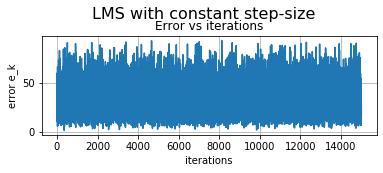

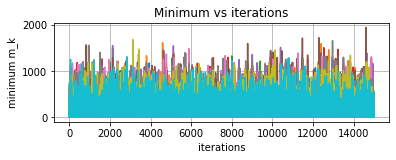

In [97]:
(k_iterations, ck) = lms_constant_step_size(d, U, c_k, tol, iterMax)

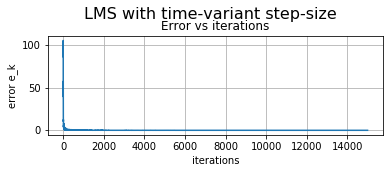

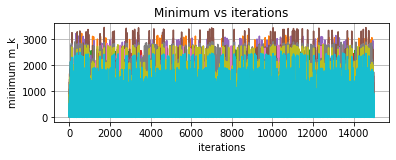

In [98]:
(k_iterations, ck) = lms_time_variant_step_size(d, U, c_k, tol, iterMax)